In [1]:
import stanza
import graphviz
import os
import json

import networkx as nx
import pandas as pd
import numpy as np

from tuw_nlp.grammar.text_to_4lang import TextTo4lang
from tuw_nlp.graph.fourlang import FourLang
from tuw_nlp.text.pipeline import CachedStanzaPipeline, CustomStanzaPipeline
from graphviz import Source

In [2]:
config = {
    "lang": "en",
    "depth": 0,
    "substitute": False   
}
data = {
 "dir": "data"
}

In [3]:
text_to_4lang = TextTo4lang(config["lang"], config["lang"] + "_nlp_cache")

nlp = stanza.Pipeline(config["lang"])

2021-11-08 17:04:14 WARNING: Can not find mwt: default from official model list. Ignoring it.
2021-11-08 17:04:14 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |
| depparse  | ewt     |

2021-11-08 17:04:14 INFO: Use device: gpu
2021-11-08 17:04:14 INFO: Loading: tokenize
2021-11-08 17:04:15 INFO: Loading: pos
2021-11-08 17:04:16 INFO: Loading: lemma
2021-11-08 17:04:16 INFO: Loading: depparse
2021-11-08 17:04:16 INFO: Done loading processors!
2021-11-08 17:04:29 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| sentiment | sstplus   |
| ner       | ontonotes |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| 

In [4]:
GOLD_ATTRIBUTES = "gold_attributes"
GOLD = "labels_gold"
ANNOTATED_ATTRIBUTES = "annotated_attributes"

def create_input(directory, attribute):
    sentence = []
    label = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), "rt") as f:
            doc = json.load(f)
            for sen in doc["sens"].values():
                if doc[GOLD]:
                    lab = attribute in sen[GOLD_ATTRIBUTES]
                else:
                    lab = attribute in sen[ANNOTATED_ATTRIBUTES]
                sentence.append(sen["text"])
                label.append(lab)
    return pd.DataFrame(data=list(zip(sentence,label)),columns=["Text","Label"])



In [5]:
#Load in Data for specific feature
train_data = create_input(os.path.join(data["dir"], "train"), "Planzeichen")

#Save the labels for later. In this case its just 0,1 conversion for Planzeichen
labels = train_data.Label*1

train_data = train_data.drop([6020])

train_data

,Text,Label
0,Unverkäufliches Dienstexemplar!,False
1,M A G I S T R A T D E R S T A D T W I E N MA 2...,False
2,Der Gemeinderat hat in seiner Sitzung am 29. J...,False
3,"Bezirk, Kat. G. Stammersdorf werden unter Anwe...",False
4,Der bisher gültige Flächenwidmungsplan und Beb...,False
...,...,...
8941,Bei Errichtung unterirdischer Bauwerke sind Vo...,False
8942,Bestimmungen mit Bezeichnung des Geltungsberei...,True
8943,Für die mit BB1 bezeichnete Grundfläche wird b...,True
8944,Für die mit BB2 bezeichnete Grundfläche wird b...,True


In [6]:
def create_fl(sentence, depth=config["depth"], substitute=config["substitute"]):
    fl_graphs = list(text_to_4lang(sentence, depth=int(depth), substitute=substitute))
    g = fl_graphs[0]
    for n in fl_graphs[1:]:
        g = nx.compose(g, n)
    fl = FourLang(g, 0)
    if int(depth):
        text_to_4lang.expand(fl, depth=int(depth), substitute=substitute)
    # sen = nlp(sentence).sentences[0]
    return fl

In [7]:
def visualize(sentence):
    dot = graphviz.Digraph()
    dot.node("0", "ROOT", shape="box")
    for token in sentence.tokens:
        for word in token.words:
            dot.node(str(word.id), word.text)
            dot.edge(str(word.head), str(word.id),
                     label=word.deprel)
    return dot

In [11]:
for index, row in train_data.iterrows():
    print(f"{index}: {row['Text'][:30]}")
    if row["Text"] and row["Text"] != "":
        fl = create_fl(row["Text"])
    else:
        fl = None
    train_data.at[index,"4lang"] = fl

0: Unverkäufliches Dienstexemplar
1: M A G I S T R A T D E R S T A 
2: Der Gemeinderat hat in seiner 
3: Bezirk, Kat. G. Stammersdorf w
4: Der bisher gültige Flächenwidm
5: Die roten Planzeichen gelten a
6: Für die rechtliche Bedeutung d
7: September 1996 maßgebend, die 
8: Für die Querschnitte der Verke
9: Seite - 2 -
10: Gemäß § 5 (4) der Bauordnung f
11: Gemäß § 3 Wiener Kleingartenge
12: Die mit Eklw/BB2 bezeichnete F
13: Von der mit Eklw P BB3 bezeich
14: Der Abteilungsleiter: Dipl.-In
15: Unverkäufliches Dienstexemplar
16: M A G I S T R A T D E R S T A 
17: Der Gemeinderat hat in seiner 
18: Bezirk, Kat. G. Leopoldstadt s
19: Die roten Planzeichen gelten a
20: Für die rechtliche Bedeutung d
21: September 1996 maßgebend, die 
22: Für die Querschnitte der Verke
23: Seite - 2 -
24: Gemäß § 5 Abs.4 der BO für Wie
25: An allen Baulinien ist die Err
26: Bauelemente, die der Gliederun
27: Der höchste Punkt der zur Ausf
28: Für alle Flächen, für die die 
29: Einfriedungen an seitlichen u

512: Die roten Planzeichen gelten a
513: Für die rechtliche Bedeutung d
514: September 1996 maßgebend, die 
515: Seite - 2 -
516: Gemäß § 5 (2) lit. c der BO fü
517: In allen Verkehrsflächen östli
518: Gemäß § 5 (4) der BO für Wien 
519: Für das gesamte Plangebiet gül
520: Erker dürfen die Baulinien nic
521: Vorstehende Bauelemente, die d
522: Die Gebäude dürfen mit maximal
523: Bebaubare, aber unbebaut bleib
524: Pro Bauplatz dürfen Nebengebäu
525: Ab einer Grundfläche von 5 m² 
526: Einfriedungen an seitlichen un
527: Für Teilbereiche des Plangebie
528: Auf den mit BB1 bezeichneten B
529: Entlang der mit BB2 bezeichnet
530: Gemäß § 5 (7) der BO für Wien 
531: Der Abteilungsleiter: Dipl.-In
532: Unverkäufliches DienstexernDla
533: MAGISTRAT DER STADT WIEN M A 2
534: Der Gemeinderat hat in seiner 
535: Bezirk, Kat. G. Ober St. Veit 
536: Die roten Planzeichen gelten a
537: Für die rechtliche Bedeutung d
538: Für die Querschnitte der Verke
539: In allen Verkehrsreichen des P
540: Gemäß 

811: September 1996 maßgebend, die 
812: Für die Querschnitte der Verke
813: Seite - 2 -
814: Gemäß § 5 (4) der Bauordnung f
815: Gemäß § 5 (4) der Bauordnung f
816: Auf den mit BB1 bezeichneten F
817: Die mit Hauptgebäuden bebauten
818: Auf den mit BB2 bezeichneten F
819: m² je Bauplatz betragen.
820: Auf der mit BB3 bezeichneten F
821: Die Gebäudehöhe darf 6 m nicht
822: Auf den mit BB4 bezeichneten F
823: Es wird darauf hingewiesen, da
824: Der Abteilungsleiter: Dipl.-In
825: Unverkäufliches Dienstexemplar
826: M A G I S T R A T D E R S T A 
827: Der Gemeinderat hat in seiner 
828: Bezirk, Kat. G. Leopoldau und 
829: Die bisher gültigen Flächenwid
830: Die roten Planzeichen gelten a
831: Für die rechtliche Bedeutung d
832: September 1996 maßgebend, die 
833: Seite - 2 -
834: Für die Querschnitte der Verke
835: Der Querschnitt der Straße Cod
836: Gemäß § 5 (4) und teilweise un
837: Auf den mit BB1 bezeichneten B
838: Auf den mit BB2 bezeichneten B
839: Der höchste Punkt der zur Erri


1085: Pr. Zl 1048/2003-GSV, den folg
1086: Bezirk, Kat. G. Simmering werd
1087: Der bisher gültige Flächenwidm
1088: Die roten Planzeichen gelten a
1089: Für die rechtliche Bedeutung d
1090: Für die Querschnitte der Verke
1091: In den Verkehrsflächen der Sim
1092: Seite 2
1093: Gemäß § 5 (4) der Bauordnung f
1094: Textliche Bestimmungen ohne Pl
1095: Im gesamten Plangebiet darf be
1096: Für Gebäude bis zu einer Gebäu
1097: Technische bzw. der Belichtung
1098: Für nicht bebaute, aber bebaub
1099: Besondere Bestimmungen mit Pla
1100: Auf den mit BB1 bezeichneten F
1101: Auf den mit G BB2 bezeichneten
1102: Die Dächer der Gebäude, die au
1103: Auf den mit Dg bezeichneten Fl
1104: Gemäß § 5 (7) bzw. § 4 (3) der
1105: Auf den mit BB4 bezeichneten F
1106: Der darüber liegende Raum wird
1107: Auf der mit BB5 bezeichneten F
1108: Der darüber liegende Raum wird
1109: Die mit BB6 bezeichnete Fläche
1110: Der Abteilungsleiter: Dipl.-In
1111: Unverkäufliches Dienstexemplar
1112: MAGISTRAT DER STAD

1353: Ab dieser Höhe ist eine Überba
1354: Auf den mit BBS bezeichneten u
1355: Gemäß § 4 (3) und § 5 (7) der 
1356: Für die mit BBS bezeichneten B
1357: Für die mit BB7 bezeichneten B
1358: Der Abteilungsleiter Dipl.-Ing
1359: Unverkäufliches Dienstexemplar
1360: MAGISTRAT DER STADT WIEN MA 21
1361: Der Gemeinderat hat in seiner 
1362: Bezirk, Kat. G. Inzersdorf Sta
1363: Die bisher gültigen Flächenwid
1364: Die roten Planzeichen gelten a
1365: Für die rechtliche Bedeutung d
1366: Für die Querschnitte der Verke
1367: In der Verkehrsfläche Otto-Pro
1368: Gemäß § 5 (4) der Bauordnung f
1369: Gemäß § 5 (4) und teilweise un
1370: Auf den mit BB1 bezeichneten F
1371: Für die mit BB2 bezeichnete Fl
1372: Der Abteilungsleiter: Dipl.-In
1373: Herbert Binder Senatsrat
1374: Unverkäufliches Dienstexemplar
1375: MAGISTRAT DER STADT WIEN MA21 
1376: Der Gemeinderat hat in seiner 
1377: Bezirk, Kat. G. Brigitfenau we
1378: Die roten Planzeichen gelten a
1379: Für die rechtliche Bedeutung d
1380: O

1613: Bebaubare, aber unbebaut bleib
1614: Flachdächer von Gebäuden sind 
1615: Technische bzw. der Belichtung
1616: Gemäß § 5 (4) der Bauordnung f
1617: Die Errichtung von Bürohäusern
1618: Für zur Errichtung gelangende 
1619: Technische bzw. der Belichtung
1620: Mindestens 10 % der Grundfläch
1621: Gemäß § 5 (4) der Bauordnung f
1622: In den mit BB1 gekennzeichnete
1623: In den mit BB2 gekennzeichnete
1624: In den mit BB3 gekennzeichnete
1625: In den mit IG gewidmeten und m
1626: Jedoch müssen zur Errichtung g
1627: Die bebaute Fläche von Hochreg
1628: Die mit P BB5 bezeichnete Fläc
1629: Die Errichtung von Pergolen is
1630: Mindestens 20 % dieser Fläche 
1631: Die Oberfläche der Stellplätze
1632: Auf der mit BB6 bezeichneten F
1633: Der Abteilungsleiter: Dipl.-In
1634: Herbert Binder Senatsrat
1635: Unverkäufliches Dienstexemplar
1636: MAGISTRAT DER STADT WIEN MA 21
1637: Der Gemeinderat hat in seiner 
1638: Bezirk, Kat. G. Liesing und Si
1639: Die bisher gültigen Flächenwid
1640: D

1890: Gemäß § 4 (3) der BO für Wien 
1891: Der Abteilungsleiter: Dipl.-In
1892: Unverkäufliches Dienstexemplar
1893: MAGISTRAT DER STADT WIEN MA 21
1894: Der Gemeinderat hat in seiner 
1895: Pr. Zl 1000/2003-GSV, den folg
1896: Bezirk, Kat. G. Neuwaldegg wer
1897: Die bisher gültigen Flächenwid
1898: Die roten Planzeichen gelten a
1899: Für die rechtliche Bedeutung d
1900: Für die Querschnitte der Verke
1901: Der Hauptweg von Bachzeile bis
1902: Seite 2
1903: Gemäß § 5 Abs. 4 der Bauordnun
1904: Bei den innerhalb des Baulande
1905: Soweit die zulässige Gebäudehö
1906: Einfriedungen auf gärtnerisch 
1907: Die mit Nebengebäuden bebaute 
1908: Die Dächer der zur Errichtung 
1909: Technische bzw. der Belichtung
1910: Nicht bebaute, jedoch bebaubar
1911: Innerhalb der als Bauland gewi
1912: Gemäß § 5 Abs. 4 der Bauordnun
1913: Innerhalb der mit BB1 bezeichn
1914: Für den Gebäudeumriss ist eine
1915: Innerhalb der mit BB2 bezeichn
1916: v. H. bzw. 100 m² je Bauplatz 
1917: Auf den als Grünla

2163: Für den Querschnitt des Rauten
2164: Gemäß § 5 (4) der Bauordnung f
2165: Im gesamten Plangebiet darf de
2166: Im Bauland sind alle bebaubare
2167: Gemäß § 5 (4) der Bauordnung f
2168: Auf den mit BB1 bezeichneten F
2169: Entlang der mit BB2 bezeichnet
2170: Auf den mit BB3 bezeichneten F
2171: Gebäude bzw. Gebäudeteile, die
2172: Bei der Ausführung der Pultdäc
2173: Auf den mit BB4 bezeichneten F
2174: Im Kupplungsfall darf die Läng
2175: Feuermauern an der Grundgrenze
2176: Auf den mit L BB5 bezeichneten
2177: Auf den mit L BB6 bezeichneten
2178: Auf den mit SwwL BB7 bezeichne
2179: Der Abteilungsleiter: Dipl.-In
2180: Unverkäufliches Dienstexemplar
2181: MAGISTRAT DER STADT WIEN MA 21
2182: Der Gemeinderat hat in seiner 
2183: Bezirk, Kat. G. Großjedlersdor
2184: Der bisher gültige Flächenwidm
2185: Die roten Planzeichen gelten a
2186: Für die rechtliche Bedeutung d
2187: Für die Querschnitte der Verke
2188: Im Straßenzug Code 6394, in de
2189: Gemäß § 5 (4) der Bauordnung f
2

2439: die schwarzen Planzeichen beha
2440: Für die rechtliche Bedeutung d
2441: Bestimmungen mit Bezeichnung d
2442: Auf den mit BB7 bezeichneten G
2443: Auf den mit BB8 bezeichneten F
2444: Im Übrigen behalten die mit Ge
2445: Der Abteilungsleiter: Dipl.-In
2446: MAGISTRAT DER STADT WIEN MA 21
2447: Der Gemeinderat hat in seiner 
2448: Bezirk, Kat. G. Süßenbrunn wer
2449: Die bisher gültigen Flächenwid
2450: Die roten Planzeichen gelten a
2451: Für die rechtliche Bedeutung d
2452: Für die Querschnitte der Verke
2453: Gemäß § 5 (4) der Bauordnung f
2454: Auf den mit BB1 bezeichneten F
2455: Entlang der mit BB2 bezeichnet
2456: Der Abteilungsleiter: Dipl.-In
2457: Herbert Binder Senatsrat
2458: MAGISTRAT DER STADT WIEN MA 21
2459: Der Gemeinderat hat in seiner 
2460: Bezirk, Kat. G. Süßenbrunn wer
2461: Bestimmungen des Plans Die rot
2462: die schwarzen Planzeichen beha
2463: Für die rechtliche Bedeutung d
2464: September 2007 maßgebend, die 
2465: Bestimmungen ohne Bezeichnung 
2466: F

2699: Innerhalb der mit BB 2 bezeich
2700: Auf der mit BB 3 bezeichneten 
2701: Auf den mit BB 4 bezeichneten 
2702: In den als Wohnzone ausgewiese
2703: Auf den mit Ak öDg bezeichnete
2704: Auf den mit Dg bezeichneten Fl
2705: Bestimmungen gemäß § 5 Abs. 7 
2706: Für die mit BB 5 bezeichnete G
2707: Auf der mit BB 6 bezeichneten 
2708: Der Raum darüber wird der öffe
2709: Gemäß § 5 Abs. 4 lit. c in Ver
2710: An der Geschäftsstraße ist die
2711: 1007 1447/3 708 1447/2 709 144
2712: Unverkäufliches Dienstexemplar
2713: MAGISTRAT DER STADT WIEN MA 21
2714: Der Gemeinderat hat in seiner 
2715: Bezirk, Kat. G. Penzing und Un
2716: Soweit für dieses Gebiet Fläch
2717: Die roten Planzeichen gelten a
2718: Für die rechtliche Bedeutung d
2719: Für die Querschnitte der Verke
2720: In der Hadikgasse und Zehetner
2721: Gemäß § 5 Abs. 4 der BO für Wi
2722: Entlang von Baulinien sind Erk
2723: Bei den zur Errichtung gelange
2724: Bei Nebengebäuden die auf gärt
2725: Die Dächer dieser Nebengebäude
2

2951: Darüber hinaus gehende nicht r
2952: In Verbindung der Punkte A-B u
2953: In Verbindung der Punkte L-M i
2954: Auf den mit BB15 bezeichneten 
2955: Bei Überbauung der Flächen im 
2956: Gemäß § 4 (3) und 5 (7) der BO
2957: Für den mit BB7 bezeichneten B
2958: Für die mit BB8 bezeichneten B
2959: Für den mit BB12 bezeichneten 
2960: Die für die Überbauung notwend
2961: Für den mit BB13 bezeichneten 
2962: Gemäß § 3 Wiener Kleingartenge
2963: Der Abteilungsleiter: Dipl.-In
2964: Herbert Binder Senatsrat
2965: MAGISTRAT DER STADT WIEN MA 21
2966: Der Gemeinderat hat in seiner 
2967: Bezirk, Kat. G. Leopoldau werd
2968: Bestimmungen des Plans Die rot
2969: die schwarzen Planzeichen beha
2970: Für die rechtliche Bedeutung d
2971: September 2007 maßgebend, die 
2972: Bestimmungen für die Ausgestal
2973: Für die Ausgestaltung von Verk
2974: Bestimmungen mit Bezeichnung d
2975: Auf den mit BB1 bezeichneten B
2976: Auf den mit BB4 bezeichneten G
2977: Technische bzw. der Belichtung
2978: D

3238: Bei Teilung dieser Flächen auf
3239: Gemäß § 5 (4) der BO für Wien 
3240: Auf den mit BB1 bezeichneten G
3241: Auf den mit BB2 bezeichneten G
3242: Die mit BB3 bezeichnete Grundf
3243: Auf den mit BB4 bezeichneten G
3244: Auf der mit BB5 bezeichneten G
3245: Die Dachneigung darf maximal 4
3246: Die bebaute Grundfläche darf m
3247: Auf der mit BB6 bezeichneten G
3248: Die Errichtung von Wohngebäude
3249: Die Gebäudehöhe darf maximal 4
3250: Die bebaute Grundfläche darf m
3251: Auf der mit BB7 bezeichneten G
3252: Die bebaute Grundfläche darf m
3253: Auf der mit BB8 bezeichneten G
3254: Der höchste Punkt des zu erric
3255: Auf der mit BB9 bezeichneten G
3256: Auf der mit BB10 bezeichneten 
3257: Auf der mit BB11 bezeichneten 
3258: Auf der mit BB12 bezeichneten 
3259: Der Abteilungsleiter: Dipl.-In
3260: Herbert Binder Senatsrat
3261: MAGISTRAT DER STADT WIEN MA 21
3262: Der Gemeinderat hat in seiner 
3263: Bezirk, Kat. G. Donaufeld und 
3264: Die bisher gültigen Flächenwid
3265: D

3526: Entlang der Baulinien in der S
3527: Struktureinheit 2 (StrE2)
3528: Die durch Fluchtlinien abgegre
3529: Das Ausmaß des oberirdisch umb
3530: Auf den mit BB14 bezeichneten 
3531: Auf den verbleibenden Flächen 
3532: Die Dächer der zur Errichtung 
3533: Technische bzw. der Belichtung
3534: Auf den mit Ak bezeichneten Gr
3535: Entlang der Baulinie in der Er
3536: Struktureinheit 3 (StrE3)
3537: Die durch Fluchtlinien abgegre
3538: Das Ausmaß des oberirdisch umb
3539: Die Gebäudehöhe der zur Errich
3540: Die Dächer der zur Errichtung 
3541: Technische bzw. der Belichtung
3542: Struktureinheit 4 (StrE4)
3543: Die durch Fluchtlinien abgegre
3544: Das Ausmaß des oberirdisch umb
3545: Die Gebäudehöhe der zur Errich
3546: Auf der mit GV bezeichneten Gr
3547: Die Dächer der zur Errichtung 
3548: Technische bzw. der Belichtung
3549: Entlang der Baulinie in der St
3550: Struktureinheit 5 (StrE5)
3551: Die durch Fluchtlinien abgegre
3552: Das Ausmaß des oberirdisch umb
3553: Die Gebäudehöhe

3801: Eine Überbauung der Grundfläch
3802: Auf den mit Dg BB9 bezeichnete
3803: Bei Überbauung der Grundfläche
3804: Formatiert: Nummerierung und
3805: Im Bereich zwischen den mit A-
3806: Der öffentliche Durchgang ist 
3807: Gemäß § 5 (7) der Bauordnung f
3808: Gemäß § 77 der Bauordnung für 
3809: Das gemäß § 77 der Bauordnung 
3810: Die mit GB StrG BB11 bezeichne
3811: Das höchste zulässige Ausmaß d
3812: Die Gebäudehöhe darf maximal 4
3813: Auf der mit GB StrG G BB12 bez
3814: Gemäß § 3 Wiener Kleingartenge
3815: Die bebaute Fläche der als Geb
3816: Die Gebäudehöhe darf maximal 3
3817: Der Abteilungsleiter: Dipl.-In
3818: Herbert Binder Senatsrat
3819: MAGISTRAT DER STADT WIEN MA 21
3820: Der Gemeinderat hat in seiner 
3821: Bezirk, Kat. G. Inzersdorf wer
3822: Die roten Planzeichen gelten a
3823: Für die rechtliche Bedeutung d
3824: Für die Querschnitte der Verke
3825: In den Straßenzügen Heizwerkst
3826: In den Straßenzügen Großmarkts
3827: 8-24) und Südrandstraße (zwisc
3828: Gem

4073: Herbert Binder Senatsrat
4074: MAGISTRAT DER STADT WIEN MA 21
4075: Der Gemeinderat hat in seiner 
4076: Bezirk, Kat. G. Auhof, Speisin
4077: Die roten Planzeichen gelten a
4078: Für die rechtliche Bedeutung d
4079: Für die Querschnitte der Verke
4080: Innerhalb des Plangebietes sin
4081: In der Hermesstraße ist die Ba
4082: Gemäß § 5 (4) der Bauordnung f
4083: An den Gebäudefronten, die unm
4084: Die in der gärtnerisch auszuge
4085: Nicht bebaute, aber bebaubare 
4086: In jenen Bereichen, für welche
4087: Darüber hinaus ist in jenen Be
4088: Einfriedungen dürfen an seitli
4089: Ab einer Höhe von 0,5 m muss d
4090: Die Errichtung von Stützmauern
4091: Gemäß § 5 (4) der Bauordnung f
4092: Im Bereich der Siedlung Hermes
4093: Im übrigen Plangebiet darf der
4094: Auf den mit BB1 bezeichneten F
4095: In den mit BB2 bezeichneten Be
4096: Auf den mit BB3 bezeichneten F
4097: Auf der mit BB4 bezeichneten F
4098: Auf den mit BB5 bezeichneten F
4099: Auf den mit BB6 bezeichneten F
4100: A

4332: Für die mit BB11 bezeichneten 
4333: Der darunter liegende Raum wir
4334: Für die mit BB12 bezeichnete G
4335: Für die mit BB13 bezeichnete G
4336: Die Errichtung eines Flugdache
4337: Der Raum bis zur Deckenkonstru
4338: Die Errichtung unterirdischer 
4339: Für die mit BB14 bezeichneten 
4340: Der darunter liegende Raum ist
4341: Die Errichtung unterirdischer 
4342: Der Abteilungsleiter: Dipl.-In
4343: MAGISTRAT DER STADT WIEN MA 21
4344: Der Gemeinderat hat in seiner 
4345: Bezirk, Kat. G. Mariahilf sowi
4346: Die roten Planzeichen gelten a
4347: Für die rechtliche Bedeutung d
4348: Für die Querschnitte der Verke
4349: In der Mariahilfer Straße, Sch
4350: Gemäß § 5 Abs. 4 der BO für Wi
4351: An allen öffentlichen Verkehrs
4352: Bauelemente, die der Gliederun
4353: Der höchste Punkt des Daches d
4354: Bebaubare, von Bebauung freibl
4355: Pro Bauplatz darf nur ein Nebe
4356: Die Dächer der zur Errichtung 
4357: Technische bzw. der Belichtung
4358: Einfriedungen an seitlichen un
4

4610: In jenen Bereichen, für welche
4611: Entsprechend § 79 (7) der BO f
4612: Einfriedungen dürfen an seitli
4613: Im Bauland/Gemischtes Baugebie
4614: Gemäß § 5 (4) der Bauordnung f
4615: Auf den mit BB1 bezeichneten F
4616: In den mit BB2 bezeichneten Be
4617: Nebengebäude gemäß § 82 (4) dü
4618: Die mit BB4 bezeichneten Fläch
4619: Innerhalb der mit BB5 bezeichn
4620: Innerhalb der mit BB6 bezeichn
4621: An den mit BB7 bezeichneten Fl
4622: Auf den mit BB8 bezeichneten F
4623: Die Dachflächen müssen zu mind
4624: Der Abteilungsleiter: Dipl.-In
4625: MAGISTRAT DER STADT WIEN MA 21
4626: Der Gemeinderat hat in seiner 
4627: Bezirk, Kat. G. Stammersdorf u
4628: Die bisher gültigen Flächenwid
4629: Die roten Planzeichen gelten a
4630: Für die rechtliche Bedeutung d
4631: Für die Querschnitte der Verke
4632: Die Querschnitte der Johann-We
4633: Die Querschnitte der Gassen 95
4634: Die im Plangebiet liegenden Te
4635: Gemäß § 5 (4) der Bauordnung f
4636: Nicht bebaute, jedoch bebaubar
4

4882: Bezirk, Kat. G. Aspern werden 
4883: Bestimmungen des Plans: Die ro
4884: die schwarzen Planzeichen beha
4885: Für die rechtliche Bedeutung d
4886: September 2007 maßgebend, die 
4887: Bestimmungen für Strukturen:
4888: Das mit StrG bezeichnete Struk
4889: Für diese Struktur wird bestim
4890: Die mit Fluchtlinien umgrenzte
4891: Der oberste Abschluss der zur 
4892: Für die mit BB4 bezeichneten G
4893: Für die mit BB5 bezeichneten G
4894: Im Übrigen behalten die mit Ge
4895: Der Abteilungsleiter: Dipl.-In
4896: MAGISTRAT DER STADT WIEN MA 21
4897: Der Gemeinderat hat in seiner 
4898: Bezirk, Kat. G. Favoriten und 
4899: Der bisher gültige Flächenwidm
4900: Die roten Planzeichen gelten a
4901: Für die rechtliche Bedeutung d
4902: Für die Querschnitte der Verke
4903: In den Verkehrsflächen Favorit
4904: Gemäß § 5 (4) der BO für Wien 
4905: Im Bauland darf bei den zur Er
4906: Auf allen Liegenschaften mit d
4907: Gemäß § 5 (4), § 5 (7) und § 7
4908: Für die mit BB1 bezeichneten F
490

5173: Auf der mit Ebd BB8 bezeichnet
5174: Die Gebäudehöhe darf höchstens
5175: Entlang der mit BB9 gekennzeic
5176: Auf den mit öDg bezeichneten G
5177: Auf der mit Spk BB10 bezeichne
5178: Die zur Errichtung gelangenden
5179: Gemäß § 3 Wiener Kleingartenge
5180: Die mit Eklw BB11 bezeichneten
5181: Auf den mit Eklw BB12 bezeichn
5182: Der Abteilungsleiter: Dipl.-In
5183: MAGISTRAT DER STADT WIEN MA 21
5184: Der Gemeinderat hat in seiner 
5185: Bezirk), Josef-Redl-Gasse, Kre
5186: Die bisher gültigen Flächenwid
5187: Die roten Planzeichen gelten a
5188: Für die rechtliche Bedeutung d
5189: Für die Querschnitte der Verke
5190: Bei einer Straßenbreite bis zu
5191: Entlang der Neuwaldegger Straß
5192: Bestimmungen gemäß § 5 Abs. 4 
5193: Der höchste Punkt der im Baula
5194: An allen Baulinien ist die Err
5195: Vorstehende Bauelemente, die d
5196: Soweit die zulässige Gebäudehö
5197: Nicht bebaute, jedoch bebaubar
5198: Innerhalb der als Bauland gewi
5199: Die mit Nebengebäuden bebaute 
5

5459: Der Gemeinderat hat in seiner 
5460: Bezirk, Kat. G. Stammersdorf w
5461: Die bisher gültigen Flächenwid
5462: Gemäß § 4 und § 5 und § 77 (in
5463: 19) der Bauordnung für Wien we
5464: Bestimmungen des Plans: Die ro
5465: Für die rechtliche Bedeutung d
5466: und 5 der Bauordnung für Wien)
5467: Für die Ausgestaltung der Quer
5468: Entlang der Fluchtlinien sind 
5469: Für die Ausgestaltung des Quer
5470: Der Querschnitt ist so auszuge
5471: Im Querschnitt ist eine Radfah
5472: Für die Ausgestaltung des Quer
5473: Der Querschnitt ist so auszuge
5474: Im Querschnitt ist eine Radfah
5475: Für die Ausgestaltung des Quer
5476: 6463, wird bestimmt:
5477: Die Querschnitte sind so auszu
5478: Für das gesamte Plangebiet wir
5479: Der höchste Punkt der zur Erri
5480: Flachdächer sind im Ausmaß von
5481: Technische bzw. der Belichtung
5482: Für die mit BB1 bezeichneten G
5483: Die Unterbrechung der geschlos
5484: Für die mit BB2 bezeichneten G
5485: Die Dachflächen von Gebäuden s
5486: Techn

5763: Flachdächer sind nach dem Stan
5764: Die Errichtung von Gebäudeteil
5765: Davon ausgenommen sind die mit
5766: Oberirdisch bebaubare, jedoch 
5767: Für Grundflächen, für die die 
5768: Bei der Errichtung von unterir
5769: Je angefangene 250 m2 Gartenfl
5770: Einfriedungen an seitlichen un
5771: Für Teile des Plangebiets wird
5772: In Schutzzonen sind die Dächer
5773: Grad und 45 Grad zu errichten.
5774: Für die mit öDg bezeichneten G
5775: Die als öffentliche Durchgänge
5776: Bestimmungen mit Bezeichnung d
5777: Für die mit BB1 bezeichneten G
5778: Ein Gebäude darf höchstens 8,0
5779: Bei Errichtung von Gebäuden an
5780: Die dem Hof zugewandten Fronte
5781: Die Dächer der Flügelbauten si
5782: Die festgesetzte Gebäudehöhe d
5783: Für die mit BB2 bezeichneten G
5784: Die Befestigung der Oberfläche
5785: Die Errichtung von Gebäudeteil
5786: Für die mit BB3 bezeichneten G
5787: Für die mit G BB4 bezeichneten
5788: Für die mit BB5 bezeichneten G
5789: Der Raum darüber darf im Rahme
5

6035: Bezirk, Kat. G. Kaiserebersdor
6036: Bestimmungen des Plans Die rot
6037: die schwarzen Planzeichen beha
6038: Für die rechtliche Bedeutung d
6039: Im Übrigen behalten die mit Ge
6040: Der Abteilungsleiter: (interim
6041: MAGISTRAT DER STADT WIEN MA 21
6042: Der Gemeinderat hat in seiner 
6043: Bezirk, Kat. G. Leopoldau werd
6044: Die bisher gültigen Flächenwid
6045: Die roten Planzeichen gelten a
6046: Für die rechtliche Bedeutung d
6047: Für die Querschnitte der Verke
6048: Der im Plangebiet liegende Ant
6049: Gemäß § 5 (4) der Bauordnung f
6050: Die Einleitung von Niederschla
6051: Dieses Verbot gilt nicht für V
6052: Der höchste Punkt der zur Erri
6053: Gemäß § 5 (4) der Bauordnung f
6054: Für die mit BB1 bezeichneten G
6055: Für die mit G und BB2 bezeichn
6056: Für die mit BB3 bezeichneten G
6057: Für die mit BB4 bezeichnete Gr
6058: Auf der bezeichneten Grundfläc
6059: Für die mit BB5 bezeichnete Gr
6060: Für die BB6 bezeichneten Grund
6061: Der Abteilungsleiter: Dipl.-In
6

6315: Für die rechtliche Bedeutung d
6316: Für die Querschnitte der Verke
6317: In der Spallartgasse und in de
6318: Gemäß § 5 Abs. 4 der BO für Wi
6319: Entlang von Baulinien an allen
6320: Bei den zur Errichtung gelange
6321: Flachdächer sind nach dem Stan
6322: Technische, bzw. der Belichtun
6323: Die bebaubaren, aber von Bebau
6324: Für alle Flächen, für die die 
6325: Einfriedungen an seitlichen un
6326: An der Hütteldorfer Straße ist
6327: Gemäß § 5 Abs. 4 der BO für Wi
6328: Auf den mit BB 1 bezeichneten 
6329: Innerhalb der mit G BB 2 bezei
6330: Auf den mit G BB 3 bezeichnete
6331: Die Dächer von Nebengebäuden s
6332: Der Abteilungsleiter: Dipl.-In
6333: MAGISTRAT DER STADT WIEN MA 21
6334: Der Gemeinderat hat in seiner 
6335: Bezirk, Kat. G. Stadlau und As
6336: Die bisherigen Flächenwidmungs
6337: Gemäß § 4 und § 5 der Bauordnu
6338: Bestimmungen des Plans: Die ro
6339: Für die rechtliche Bedeutung d
6340: Bestimmungen für die Ausgestal
6341: Für die Ausgestaltung von Verk
6

6598: Im Bauland sind Flachdächer na
6599: Solarenergetische Nutzung ist 
6600: Weiters sind technische bzw. d
6601: Mit Ausnahme der als Betriebsb
6602: Gemäß § 5 Abs. 4 der BO für Wi
6603: Auf den mit BB1 bezeichneten G
6604: Auf den mit BB2 bezeichneten G
6605: Auf den mit BB3 bezeichneten G
6606: Gemäß § 4 Abs. 3 und § 5 Abs. 
6607: Gemäß § 7c der BO für Wien wer
6608: Der Abteilungsleiter: Dipl.-In
6609: MAGISTRAT DER STADT WIEN MA 21
6610: Der Gemeinderat hat in seiner 
6611: Bezirk, Kat. G. Brigittenau we
6612: Die bisher gültigen Flächenwid
6613: Die roten Planzeichen gelten a
6614: Für die rechtliche Bedeutung d
6615: Für die Querschnitte der Verke
6616: In der Dresdner Straße, der Le
6617: Gemäß § 5 Abs. 4 der BO für Wi
6618: Der höchste Punkt der zur Erri
6619: Die Dächer der zur Errichtung 
6620: m² entsprechend dem Stand der 
6621: Technische bzw. der Belichtung
6622: Zur Errichtung gelangende Flac
6623: m² entsprechend dem Stand der 
6624: Technische bzw. der Belichtung
6

6878: Der oberste Abschluss der Bauw
6879: Für die mit BB5 bezeichneten G
6880: Für die mit BB6 bezeichneten G
6881: Es gelten die Bebauungsbestimm
6882: Für die mit BB7 bezeichneten G
6883: Für die mit BB8 bezeichneten G
6884: Der Abteilungsleiter: Dipl.-In
6885: MAGISTRAT DER STADT WIEN MA 21
6886: Der Gemeinderat hat in seiner 
6887: Bezirk, Kat. G. Landstraße wer
6888: Die bisherigen Flächenwidmungs
6889: Gemäß § 4 und § 5 der BO für W
6890: Bestimmungen des Plans: Die ro
6891: Für die rechtliche Bedeutung d
6892: Juli 2014 maßgebend, die einen
6893: Bestimmungen für die Ausgestal
6894: Bestimmungen ohne Bezeichnung 
6895: Für das gesamte Bauland wird b
6896: Die zur Errichtung gelangenden
6897: Flachdächer von Gebäuden mit e
6898: Die Einleitungsmenge von Niede
6899: Für alle Flächen, für die die 
6900: Für die dem gemischten Baugebi
6901: Bestimmungen mit Bezeichnung d
6902: Für die mit BB1 bezeichneten G
6903: Für die mit BB2 bezeichneten G
6904: Für die mit BB3 bezeichneten G
6

7198: Es wird bestimmt, dass die Nut
7199: Nr. 18/1989 in der Fassung des
7200: Nr. 35/2013, in diesem Bereich
7201: Der umbaute Raum aller auf die
7202: Bei Teilung dieser Flächen auf
7203: Der oberste Abschluss der Gebä
7204: Darüber hinaus ist die Erricht
7205: Die mit Baufluchtlinien umgren
7206: Es wird bestimmt, dass die Nut
7207: Nr. 18/1989 in der Fassung des
7208: Nr. 35/2013, in diesem Bereich
7209: Der umbaute Raum aller auf die
7210: Bei Teilung dieser Flächen auf
7211: Der oberste Abschluss der Gebä
7212: Darüber hinaus ist die Erricht
7213: Die mit Baufluchtlinien umgren
7214: Es wird bestimmt, dass die Nut
7215: Nr. 18/1989 in der Fassung des
7216: Nr. 35/2013, in diesem Bereich
7217: Der umbaute Raum aller auf die
7218: Bei Teilung dieser Flächen auf
7219: Der oberste Abschluss der Gebä
7220: Darüber hinaus ist die Erricht
7221: Die mit Baufluchtlinien umgren
7222: Es wird bestimmt, dass die Nut
7223: Nr. 18/1989 in der Fassung des
7224: Nr. 35/2013, in diesem Bereich
7

7491: Bestimmungen für die Ausgestal
7492: Für die Ausgestaltung von Verk
7493: m, soweit sie innerhalb des Pl
7494: Entlang der Fluchtlinien sind 
7495: Die Querschnitte sind so auszu
7496: Bestimmungen ohne Bezeichnung 
7497: Der höchste Punkt der zur Erri
7498: Nicht bebaute, jedoch bebaubar
7499: Die zur Errichtung gelangenden
7500: Die im Plan östlich der ÖBB-Ba
7501: Bei Teilung auf mehrere Bauplä
7502: Für die Grundflächen westlich 
7503: Für die Grundflächen östlich d
7504: Für die Verbindungen der Punkt
7505: Bei Überbauung des Durchgangs 
7506: Für die Verbindung der Punkte 
7507: Für die Verbindung der Punkte 
7508: Bei Überbauung des Durchganges
7509: Die Errichtung von unterirdisc
7510: Für die Verbindung der Punkte 
7511: Durchsichtige Teile der Lärmsc
7512: Bestimmungen mit Bezeichnung d
7513: Für die mit BB1 bezeichneten G
7514: Für die mit BB2 bezeichneten G
7515: Für die mit BB3 bezeichneten G
7516: Für die mit BB4 bezeichneten G
7517: Für die mit BB5 bezeichneten G
7

7789: m wird bestimmt: Entlang der F
7790: m Breite herzustellen.
7791: Für die Ausgestaltung der Prat
7792: Bestimmungen ohne Bezeichnung 
7793: Der höchste Punkt der zur Erri
7794: Die zur Errichtung gelangenden
7795: Die zur Errichtung gelangenden
7796: Die mit Nebengebäuden bebaute 
7797: Bebaubare, jedoch unbebaut ble
7798: Für alle Flächen, für die die 
7799: Einfriedungen an den seitliche
7800: Auf der mit Ak öDg bezeichnete
7801: Der Raum der Arkade ist zur Er
7802: Auf der mit Dg bezeichneten Fl
7803: Die Überbauung des Durchgangs 
7804: Auf der mit öDf bezeichneten F
7805: Die Überbauung der öffentliche
7806: In den als Wohnzone ausgewiese
7807: Bestimmungen mit Bezeichnung d
7808: Auf der mit BB1 bezeichneten F
7809: Auf den mit BB2 bezeichneten F
7810: Auf der mit BB3 bezeichneten F
7811: Der Raum darüber ist der Widmu
7812: Die Errichtung von Stiegenaufg
7813: Auf der mit BB4 bezeichneten F
7814: Der Raum bis 4 m über dem Nive
7815: Auf der mit BB5 bezeichneten F
7816: Der

8077: Einfriedungen dürfen 2,0 m nic
8078: Die Einleitungsmenge von Niede
8079: Bestimmungen mit Bezeichnung d
8080: Auf der zwischen den Punktepaa
8081: Auf der mit BB1 bezeichneten G
8082: Gemäß § 5 Absatz 7 der BO für 
8083: Für die mit BB2 bezeichnete Fl
8084: Für die mit BB3 bezeichneten F
8085: Der Abteilungsleiter: Dipl.-In
8086: MAGISTRAT DER STADT WIEN MA 21
8087: Der Gemeinderat hat in seiner 
8088: Die bisherigen Flächenwidmungs
8089: Gemäß §§ 4 und 5 der BO für Wi
8090: Bestimmungen des Plans: Die ro
8091: Für die rechtliche Bedeutung d
8092: Juli 2014 maßgebend, die einen
8093: Bestimmungen für die Ausgestal
8094: Für die Ausgestaltung von Verk
8095: Die Querschnitte der Oberzelle
8096: Der Querschnitt der Viehmarktg
8097: Bestimmungen ohne Bezeichnung 
8098: Oberirdisch bebaubare, jedoch 
8099: Für alle Flächen, für die die 
8100: Die zur Errichtung gelangenden
8101: Der höchste Punkt des Daches d
8102: In der Lissagasse dürfen Erker
8103: Für die mit Ak bezeichneten Gr
8

8354: Für die Struktureinheit 4 (Str
8355: Die mit Baufluchtlinien und Gr
8356: Der umbaute Raum der Bauwerke 
8357: Die Gebäudehöhe darf höchstens
8358: Die Wohnnutzfläche gemäß § 2 Z
8359: Für die Struktureinheit 5 (Str
8360: Die mit Baufluchtlinien umgren
8361: Der umbaute Raum der Bauwerke 
8362: Die Gebäudehöhe darf höchstens
8363: Die Wohnnutzfläche gemäß § 2 Z
8364: Für die Struktureinheit 6 (Str
8365: Die mit Baufluchtlinien und Gr
8366: Der umbaute Raum der Bauwerke 
8367: Die Gebäudehöhe darf höchstens
8368: Die Wohnnutzfläche gemäß § 2 Z
8369: Für die Struktureinheit 7 (Str
8370: Die mit Baufluchtlinien umgren
8371: Der umbaute Raum der Bauwerke 
8372: Die Gebäudehöhe darf höchstens
8373: Die Wohnnutzfläche gemäß § 2 Z
8374: Der Abteilungsleiter: (interim
8375: MAGISTRAT DER STADT WIEN MA 21
8376: Der Gemeinderat hat in seiner 
8377: Bezirk, Kat. G. Liesing sowie 
8378: Die bisherigen Flächenwidmungs
8379: Gemäß §§ 4 und 5 der BO für Wi
8380: Bestimmungen des Plans: Die ro
8

8689: Die Ergebnisse des Umweltberic
8690: Zusammenfassend wird erklärt, 
8691: Der Abteilungsleiter: Dipl.-In
8692: MAGISTRAT DER STADT WIEN MA 21
8693: Der Gemeinderat hat in seiner 
8694: Bezirk, Kat. G. Kalksburg sowi
8695: Die bisherigen Flächenwidmungs
8696: Gemäß §§ 4 und 5 der BO für Wi
8697: Bestimmungen des Plans: Die ro
8698: Für die rechtliche Bedeutung d
8699: Juli 2014 maßgebend, die einen
8700: Bestimmungen für die Ausgestal
8701: Für die Ausgestaltung von Verk
8702: Für die Ausgestaltung der Quer
8703: Bestimmungen ohne Bezeichnung 
8704: Für das gesamte Plangebiet wir
8705: Die zur Errichtung gelangenden
8706: Der höchste Punkt der Dächer d
8707: Sofern nichts anderes bestimmt
8708: An der Breitenfurter Straße dü
8709: Für Grundflächen, für die die 
8710: Die bebaute Fläche der nach de
8711: Unterirdische Gebäude bzw. Geb
8712: Bestimmungen mit Bezeichnung d
8713: Für die mit BB1 bezeichneten G
8714: Für die mit BB2 bezeichneten G
8715: dieses Antrags findet in diese
8

In [12]:
train_data

,Text,Label,4lang
0,Unverkäufliches Dienstexemplar!,False,<tuw_nlp.graph.fourlang.FourLang object at 0x7...
1,M A G I S T R A T D E R S T A D T W I E N MA 2...,False,<tuw_nlp.graph.fourlang.FourLang object at 0x7...
2,Der Gemeinderat hat in seiner Sitzung am 29. J...,False,<tuw_nlp.graph.fourlang.FourLang object at 0x7...
3,"Bezirk, Kat. G. Stammersdorf werden unter Anwe...",False,<tuw_nlp.graph.fourlang.FourLang object at 0x7...
4,Der bisher gültige Flächenwidmungsplan und Beb...,False,<tuw_nlp.graph.fourlang.FourLang object at 0x7...
...,...,...,...
8941,Bei Errichtung unterirdischer Bauwerke sind Vo...,False,<tuw_nlp.graph.fourlang.FourLang object at 0x7...
8942,Bestimmungen mit Bezeichnung des Geltungsberei...,True,<tuw_nlp.graph.fourlang.FourLang object at 0x7...
8943,Für die mit BB1 bezeichnete Grundfläche wird b...,True,<tuw_nlp.graph.fourlang.FourLang object at 0x7...
8944,Für die mit BB2 bezeichnete Grundfläche wird b...,True,<tuw_nlp.graph.fourlang.FourLang object at 0x7...


<AxesSubplot:ylabel='Frequency'>

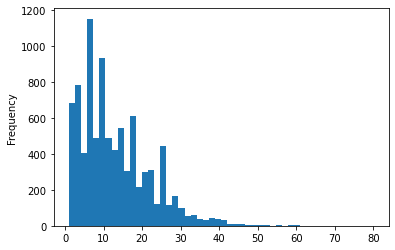

In [14]:
train_data["4lang"].apply(lambda x: len(x.G)).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

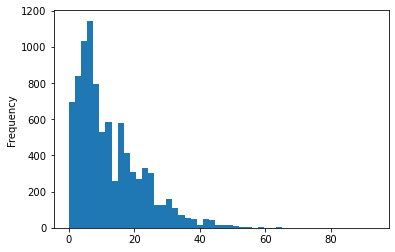

In [15]:
train_data["4lang"].apply(lambda x: len(x.G.edges)).plot.hist(bins=50)